In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Now we define the tree nodes as a graph where the spot price at every node is represented as S(i,j) where i is the tree depth or time level. S(i,j) = S0 * u^(j)* d^(i-j) where j is the no. of multiples of u at the respective node. 

In [ ]:
#Initialising Parameters:

So = 100          #Initial Stock Price
K = 100           #Strike Price
T = 1             #Time Left to Maturity in Years
r = 0.06          #Annual Risk Free Rate
N = 3             #No. of Time Steps
u = 1.1           #Spot Price Up-Factor in Binomial Model
d = 1/u           #Ensure a Recombining Symmetrical Tree
opttype = 'C'     #Option Type 'C' or 'P' for Call or Put Option
H = 150           #Up and Out Barrier for Barrier Option

In [ ]:
def binomial_tree(K,T,So,r,N,u,d,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices, Time Step N
  S = np.zeros(N + 1)
  S[0] = So * (d**N)
  for j in range (1 , N+1):
    S[j] = S[j-1] * u/d
  
  #Initialise Option Values at Maturity
  C = np.zeros(N + 1)               #4 different possible pay offs if N = 3
  for j in range(0,N+1):
    C[j] = max(0, S[j] - K)
    


  #Step backwards through Tree
  for i in np.arange(N,0,-1):
    for j in range(0,i):
      C[j] = discount * ( q*C[j+1] + (1-q)*C[j] )
  
  return C[0]

binomial_tree(K,T,So,r,N,u,d,opttype = 'C')

10.145735799928817

In [ ]:
def binomial_tree_vectorised(K,T,So,r,N,u,d,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.
  
  #Initialise Option Values at Maturity
  S = So * d** (np.arange(N,-1,-1)) * u **(np.arange(0,N+1,1))

  #Initialise Option Values
  C = np.maximum(S - K, np.zeros(N+1))

  #Step backwards through Tree
  for i in np.arange(N,0,-1):
    C = discount * (q * C[1:i+1] + (1 - q) * C[0:i])
  
  
  return C[0]

binomial_tree_vectorised(K,T,So,r,N,u,d,opttype = 'C')

10.145735799928826

In [ ]:
y = []
x = []
for i in range(1, 6000):
  if (i % 100 == 0):
    x.append(i)
    y.append(binomial_tree_vectorised(K,T,So,r,i,u,d,opttype = 'C')) 

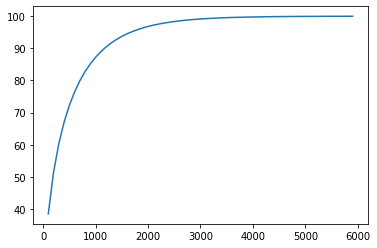

99.975487284982


In [ ]:
plt.plot(x,y)
plt.show()
print(y[-1])

In [ ]:
def barrier_tree_slow(K,T,So,r,N,u,d,H,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices at Maturity
  S =  np.zeros(N+1)
  for j in range(0,N+1):
    S[j] = So * (u**j) * (d**(N-j))

  #Option PayOff
  C = np.zeros(N+1)
  for j in range(0,N+1):
    if (opttype == 'C'):
      C[j] = max(0, S[j] - K)
    else:
      C[j] = max(0, K - S[j])

  #Check Terminal Condition PayOff 
  for j in range(0,N+1):
    S = So * (u**j) * (d**(N-j))
    if S>=H:
      C[j] = 0

  #Backward Iteration Through the Tree
  for i in np.arange(N-1, -1,-1):
    for j in range(0,i+1):
      S = So* (u**j) * (d**(i-j))
      if S >= H:
        C[j] = 0
      else:
        C[j] = discount * (q*C[j+1] + (1-q)*C[j])
  
  return C[0]

barrier_tree_slow(K,T,So,r,N,u,d,H,opttype = 'C')

10.145735799928826

In [ ]:
def barrier_tree_fast(K,T,So,r,N,u,d,H,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices at Maturity
  S = So* (u**(np.arange(0,N+1,1))) * (d**(np.arange(N,-1,-1)))

  #Option PayOff
  if opttype == 'C':
    C = np.maximum(S - K, 0)
  else:
    C = np.maximum(K - S, 0)

  #Check Terminal Condition PayOff
  C[S >= H ] = 0

  #Backward Recursion through the Tree
  for i in np.arange(N-1, -1, -1):
    S = So* (u**(np.arange(0,i+1,1))) * (d**(np.arange(i,-1,-1)))
    C[:i+1] = discount * (q * C[1:i+2] + (1-q) * C[0:i+1])
    C = C[:-1]
    C[S >= H] = 0
  
  return C[0]

barrier_tree_fast(K,T,So,r,N,u,d,H,opttype = 'C')

10.145735799928826

In [ ]:
def american_tree_slow(K,T,S0,r,N,u,d,opttype='P'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices at Maturity
  S =  np.zeros(N+1)
  for j in range(0,N+1):
    S[j] = So * (u**j) * (d**(N-j))

  #Option PayOff
  C = np.zeros(N+1)
  for j in range(0,N+1):
    if (opttype == 'C'):
      C[j] = max(0, S[j] - K)
    else:
      C[j] = max(0, K - S[j])

  #BackWard Iteration through the Tree
  for i in np.arange(N-1,-1,-1):
    for j in range(0,i+1):
      S = So * (u**j) * (d**(i-j))
      C[j] = discount * (q * C[j+1] + (1 - q) * C[j])
      if opttype == 'P':
        C[j] = max(C[j], K - S)
      else:
        C[j] = max(C[j], S - K)

  return C[0]

american_tree_slow(K,T,So,r,N,u,d,opttype='P') 

4.654588754602527

In [ ]:
def american_tree_fast(K,T,S0,r,N,u,d,opttype='P'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices at Maturity
  S = So* (u**(np.arange(0,N+1,1))) * (d**(np.arange(N,-1,-1)))

  #Option PayOff
  if opttype == 'C':
    C = np.maximum(S - K, 0)
  else:
    C = np.maximum(K - S, 0)

  #BackWard Iteration through the Tree
  for i in np.arange(N-1,-1,-1):
    S = So* (u**(np.arange(0,i+1,1))) * (d**(np.arange(i,-1,-1)))
    C[:i+1] = discount * (q * C[1:i+2] + (1-q) * C[0:i+1])
    C = C[:-1]
    if opttype == 'P':
      C = np.maximum(C, K - S)
    else:
      C = np.maximum(C, S - K)

  return C[0]

american_tree_fast(K,T,So,r,N,u,d,opttype='P') 

4.654588754602527

In [ ]:
def CRR_Method(K,T,So,r,N,sigma,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N                          #Total Time to Maturity divided by number of periods.
  u = np.exp(sigma*np.sqrt(dt))
  d = 1/u
  q = (np.exp(r * dt) - d)/(u - d)  #Risk Neutral Formula
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices, Time Step N
  S = np.zeros(N + 1)
  S[0] = So * (d**N)
  for j in range (1 , N+1):
    S[j] = S[j-1] * u/d
  
  #Initialise Option Values at Maturity
  C = np.zeros(N + 1)               #4 different possible pay offs if N = 3
  for j in range(0,N+1):
    C[j] = max(0, S[j] - K)
    


  #Step backwards through Tree
  for i in np.arange(N,0,-1):
    for j in range(0,i):
      C[j] = discount * ( q*C[j+1] + (1-q)*C[j] )
  
  return C[0]

CRR_Method(K,T,So,r,N,u,d,opttype = 'C')

In [ ]:
def JR_Method(K,T,So,r,N,sigma,opttype = 'C'):
  #Pre-Computing Constants
  dt = T/N
  nu = r - 0.5*sigma**2
  u = np.exp(nu*dt + sigma*np.sqrt(dt))
  d = np.exp(nu*dt - sigma*np.sqrt(dt))
  q = 0.5
  discount = np.exp(-r * dt)        #Discounting the Expected Pay-Offs when exercised.

  #Initialise Asset Prices, Time Step N
  S = np.zeros(N + 1)
  S[0] = So * (d**N)
  for j in range (1 , N+1):
    S[j] = S[j-1] * u/d
  
  #Initialise Option Values at Maturity
  C = np.zeros(N + 1)               #4 different possible pay offs if N = 3
  for j in range(0,N+1):
    C[j] = max(0, S[j] - K)
    
  #Step backwards through Tree
  for i in np.arange(N,0,-1):
    for j in range(0,i):
      C[j] = discount * ( q*C[j+1] + (1-q)*C[j] )
  
  return C[0]

CRR_Method(K,T,So,r,N,u,d,opttype = 'C')